In [42]:
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optimistix as optx
from tqdm import trange

# --- 1. Define Constants ---
# (Adjust these values based on your specific model needs)
params = {
    "bias": 100e-12,
    "I0": 129e-15,
    "a": 0.39,
    "b": 0.025,
    "c": 26e-2,
    "d": 0.5,
    "scale": 0.6,
    "C": 1e-13,
}


def system(state, p, input=0):
    x, y = state[0], state[1]
    z = jnp.tanh(5 * (x - y))

    # Equation for dx/dt
    dx = (
        input
        + z * p["bias"]
        - p["I0"] * jnp.exp(p["a"] * y / p["b"]) * (z + p["c"] * (p["d"] - x) * z)
        - p["bias"] * p["scale"]
    ) / p["C"]

    # Equation for dy/dt
    dy = (
        -z * p["bias"]
        + p["I0"] * jnp.exp(p["a"] * x / p["b"]) * (z + p["c"] * (p["d"] - y) * z)
        - p["bias"] * p["scale"]
    ) / p["C"]

    return jnp.asarray([dx, dy])


# --- 2. Find Equilibrium Point ---
# We solve for where dx=0 and dy=0
initial_guess = jnp.asarray([0.6, 0.3])
solver = optx.Newton(rtol=1e-3, atol=1e-2)
sol = optx.root_find(
    system, solver, initial_guess, args=params, max_steps=100000, throw=False
)
fixed_point = sol.value

print(f"Equilibrium Point found at: x = {fixed_point[0]:.4f}, y = {fixed_point[1]:.4f}")

jacobian_func = jax.jacobian(partial(system, p=params), argnums=0)
J = jacobian_func(fixed_point)
eigenvalues = jnp.linalg.eigvals(J)

print("\n--- Stability Analysis ---")
print(f"Eigenvalues: {eigenvalues}")
if jnp.all(jnp.real(eigenvalues) < 0):
    print("Result: System is STABLE at this point.")
else:
    print("Result: System is UNSTABLE at this point.")

Equilibrium Point found at: x = 0.4633, y = 0.2943

--- Stability Analysis ---
Eigenvalues: [-147.60596+8726.844j -147.60596-8726.844j]
Result: System is STABLE at this point.


In [47]:
# --- 4. Plotting the Phase Portrait ---
x_range = jnp.linspace(-1.0, 1.0, 50)
y_range = jnp.linspace(-1.0, 1.0, 50)
X, Y = np.meshgrid(x_range, y_range)
U, V = np.zeros(X.shape), np.zeros(Y.shape)

EIG = np.zeros(X.shape + (2,), dtype=np.complex64)

for i in trange(len(x_range)):
    for j in range(len(y_range)):
        vel = system([X[i, j], Y[i, j]], params, input=100e-12)
        U[i, j] = vel[0]
        V[i, j] = vel[1]

        # J = jacobian_func(jnp.asarray([X[i,j], Y[i,j]]))
        # eigenvalues = jnp.linalg.eigvals(J)
        # EIG[i,j,0] = eigenvalues[0]
        # EIG[i,j,1] = eigenvalues[1]

100%|██████████| 50/50 [00:05<00:00,  9.16it/s]


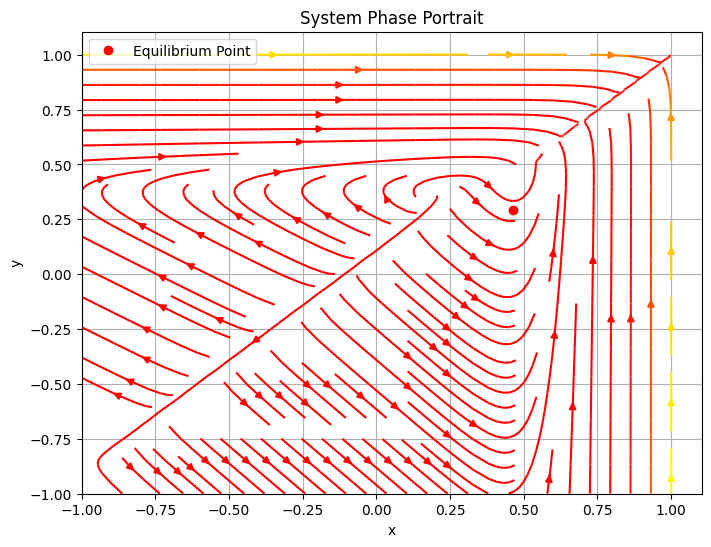

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

lw = jnp.sqrt(U**2 + V**2) / jnp.sqrt(U**2 + V**2).max()
ax.streamplot(X, Y, U, V, color=np.asarray(lw), cmap="autumn")
ax.plot(fixed_point[0], fixed_point[1], "ro", label="Equilibrium Point")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("System Phase Portrait")
ax.legend()
ax.grid(True)

# cs = ax.contourf(X, Y, jnp.all(jnp.real(EIG) < 0, axis=2))

# # # Extract colormap and normalizer
# cmap = cs.cmap
# norm = cs.norm

# # # Get color for each level (using midpoint of each range)
# colors = [cmap(norm((cs.levels[i] + cs.levels[i+1]) / 2)) for i in range(len(cs.levels)-1)]

# legend_patches = [Patch(facecolor=colors[0], label="real(EIG)>=0"), Patch(facecolor=colors[1], label="real(EIG)<0")]
# ax.legend(handles=legend_patches, loc='upper right', title='Region')
# cbar = fig.colorbar(cs)

plt.show()

In [49]:
# 1. Define a grid of states from -100 to 100
x_vals = jnp.linspace(0, 1, 50)
y_vals = jnp.linspace(0, 1, 50)
X, Y = jnp.meshgrid(x_vals, y_vals)
grid_states = jnp.stack([X.flatten(), Y.flatten()], axis=1)


# 2. Function to get the Max Real Eigenvalue at any state
def get_stability_at_state(state):
    # Calculate Jacobian at THIS specific state, not just equilibrium
    J = jax.jacobian(system, argnums=0)(state, params)
    return jnp.max(jnp.real(jnp.linalg.eigvals(J)))


def check_divergence(state, params):
    # Get Jacobian at an arbitrary state
    J = jax.jacobian(system, argnums=0)(state, params)
    return jnp.trace(J)  # Divergence = sum of diagonal elements


def lyapunov_derivative(state, eq_point, params):
    # 1. Calculate the velocity (f and g)
    vel = system(state, params)

    # 2. Gradient of V = 0.5 * (dist^2) is simply the distance vector
    grad_V = state - eq_point

    # 3. V_dot = grad_V · velocity (Dot product)
    return jnp.dot(grad_V, vel)


# 3. Map this over the entire grid
global_stability_map = jax.vmap(get_stability_at_state)(grid_states)
divs = jax.vmap(lambda s: check_divergence(s, params))(grid_states)

sol = optx.root_find(
    system, solver, jnp.asarray([0.6, 0.3]), args=params, max_steps=100000, throw=False
)
fixed_point1 = sol.value

sol = optx.root_find(
    system, solver, jnp.asarray([0.3, 0.6]), args=params, max_steps=100000, throw=False
)
fixed_point2 = sol.value

v_dot1 = jax.vmap(lambda s: lyapunov_derivative(s, fixed_point1, params))(grid_states)
v_dot2 = jax.vmap(lambda s: lyapunov_derivative(s, fixed_point2, params))(grid_states)

# 4. Check for "Global Instability"
percentage_unstable = jnp.mean(global_stability_map > 0) * 100
print(f"System is unstable in {percentage_unstable:.1f}% of the state space.")

if percentage_unstable == 100:
    print("Conclusion: The system is GLOBALLY UNSTABLE.")
elif percentage_unstable > 0:
    print("Conclusion: The system is LOCALLY UNSTABLE but may have stable regions.")

System is unstable in 20.5% of the state space.
Conclusion: The system is LOCALLY UNSTABLE but may have stable regions.


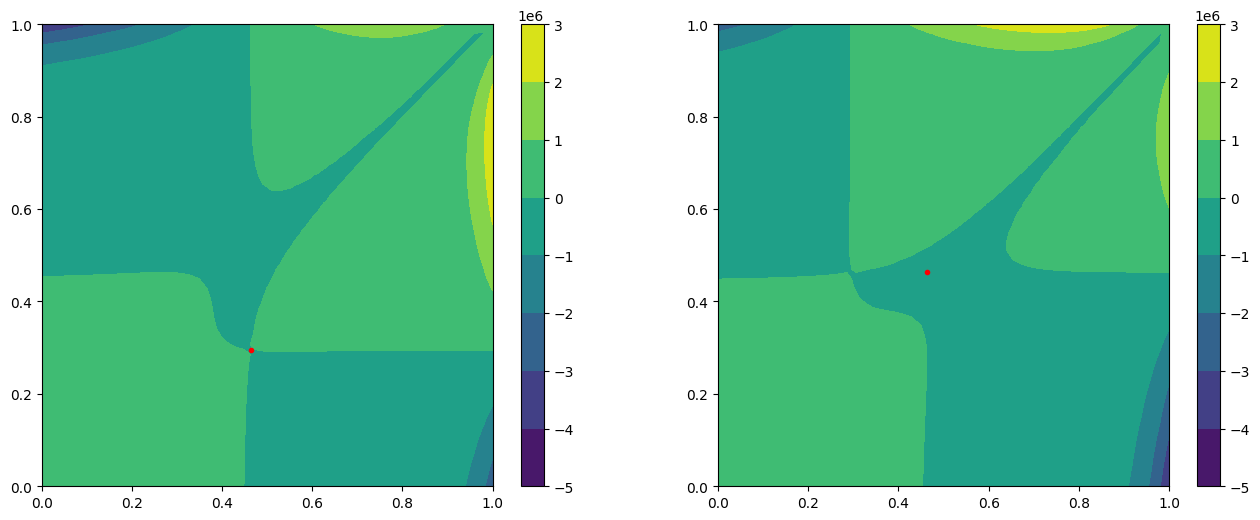

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

cs = ax[0].contourf(X, Y, v_dot1.reshape(X.shape))
cbar = fig.colorbar(cs)
ax[0].plot(fixed_point1[0], fixed_point1[1], "r.")

cs = ax[1].contourf(X, Y, v_dot2.reshape(X.shape))
cbar = fig.colorbar(cs)
ax[1].plot(fixed_point2[1], fixed_point2[1], "r.")

plt.show()